# Calculating Extreme Precipitation days using daily projections from Cal-Adapt API

In [65]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
from scipy.stats.distributions import genextreme
from scipy.stats.distributions import genpareto
from lmoments3 import distr, lmom_ratios
from scipy import special
from scipy import optimize
import math

----
# Download data
----

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to inches
    - return a new Pandas dataframe that contains all the data

In [2]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

def kgm2s_to_mm(val):
    return  (val * 86400)

In [3]:
def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'mm':
            df.value = df.value.apply(lambda x: mm_to_inches(x))
        elif units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_inches(x))
        else:
            pass
            
        # Add slug as a column
        df['series'] = slug.split('_')[2]
        
        # Add wateryear as a column
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [4]:
def get_observed():
    # Create slug
    slug = 'pr_day_livneh'
    df = process_daily_data(slug, params)
    return df

### Download observed daily timeseries

In [5]:
observedDF = get_observed()
observedDF

Processing: pr_day_livneh


,value,series,year,month,wateryear
1950-01-01,0.021879,livneh,1950,1,1950
1950-01-02,0.038984,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,0.278853,livneh,1950,1,1950
1950-01-08,0.227935,livneh,1950,1,1950
1950-01-09,0.043757,livneh,1950,1,1950
1950-01-10,0.640446,livneh,1950,1,1950


### Download projected daily timeseries

The projected daily timeseries are form 2006 - 2099/2100 and units are in kg/m2/s. You can easily modify the code to add/subtract models, scenarios, climate variables

In [6]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CNRM-CM5']
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Request parameters
    params = {'g': point}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [7]:
projectedDF = get_projections()
projectedDF

Processing: pr_day_CNRM-CM5_rcp45
Processing: pr_day_CNRM-CM5_historical


,value,series,year,month,wateryear
2006-01-01,0.000000,CNRM-CM5,2006,1,2006
2006-01-02,0.000000,CNRM-CM5,2006,1,2006
2006-01-03,0.000000,CNRM-CM5,2006,1,2006
2006-01-04,0.000000,CNRM-CM5,2006,1,2006
2006-01-05,0.000000,CNRM-CM5,2006,1,2006
2006-01-06,0.000000,CNRM-CM5,2006,1,2006
2006-01-07,0.000000,CNRM-CM5,2006,1,2006
2006-01-08,0.000000,CNRM-CM5,2006,1,2006
2006-01-09,0.000000,CNRM-CM5,2006,1,2006
2006-01-10,0.000483,CNRM-CM5,2006,1,2006


In [8]:
# Combine observed and projected data into a single dataframe
df = pd.concat([observedDF, projectedDF])
df

,value,series,year,month,wateryear
1950-01-01,0.021879,livneh,1950,1,1950
1950-01-02,0.038984,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,0.278853,livneh,1950,1,1950
1950-01-08,0.227935,livneh,1950,1,1950
1950-01-09,0.043757,livneh,1950,1,1950
1950-01-10,0.640446,livneh,1950,1,1950


----
# Number of Extreme Precipitation Days
----

Using a baseline period of wateryears 1961 - 1990, calculate the 90th, 95th and 99th percentiles of daily precipitation values within a water year from the observed data. Count number of days with values above threshold.

In [9]:
# CALCULATE THRESHOLDS
# Filter data by baseline time period
baselineDF = df.loc[(df['wateryear'] >= 1961) & (df['wateryear'] <= 1990) & (df['series'] == 'livneh')]
# Filter out zero precip values
baseline_nonzero = baselineDF.loc[(baselineDF['value'] > 0)]
threshold90 = baseline_nonzero['value'].quantile(0.90, interpolation='linear')
threshold95 = baseline_nonzero['value'].quantile(0.95, interpolation='linear')
threshold99 = baseline_nonzero['value'].quantile(0.99, interpolation='linear')
print('90th Percentile Threshold is', round(threshold90, 2), 'inch/day')
print('95th Percentile Threshold is', round(threshold95, 2), 'inch/day')
print('99th Percentile Threshold is', round(threshold99, 2), 'inch/day')

90th Percentile Threshold is 0.62 inch/day
95th Percentile Threshold is 0.87 inch/day
99th Percentile Threshold is 1.57 inch/day


In [10]:
# SELECT 90TH PERCENTILE THRESHOLD
threshold = 0.6

In [11]:
# FILTER DAYS > THRESHOLD
days = pd.DataFrame(df[df.value > threshold])
days

,value,series,year,month,wateryear
1950-01-10,0.640446,livneh,1950,1,1950
1950-01-13,0.600269,livneh,1950,1,1950
1950-02-03,0.780875,livneh,1950,2,1950
1950-02-04,0.800316,livneh,1950,2,1950
1950-10-25,0.643468,livneh,1950,10,1951
1950-10-26,0.902147,livneh,1950,10,1951
1950-11-17,1.197603,livneh,1950,11,1951
1950-11-18,1.000976,livneh,1950,11,1951
1950-12-03,0.792669,livneh,1950,12,1951
1950-12-14,0.813538,livneh,1950,12,1951


In [12]:
# Group by wateryear and count number of days for each wateryear
days_count_by_year = days.groupby(['series', 'wateryear'])['value'].count()

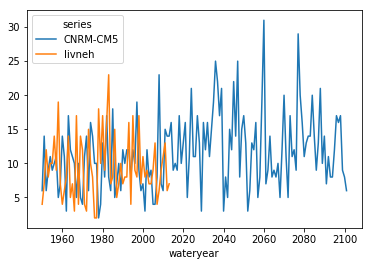

In [13]:
# Plot Number of Extreme Precipitation Days by Year
days_count_by_year.unstack('series').plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f990e0f32e8>,
      dtype=object)

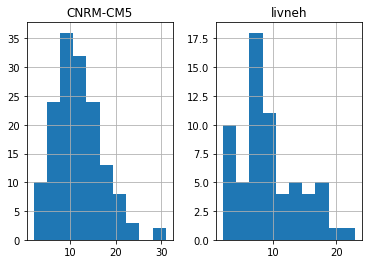

In [14]:
# Plot Histogram of Number of Extreme Precipitation Days by Year
days_count_by_year.unstack('series').hist()

----
# Extreme Value Analysis
----

### Approach 1: Block Maxima/Annual Maximum Series (AMS)

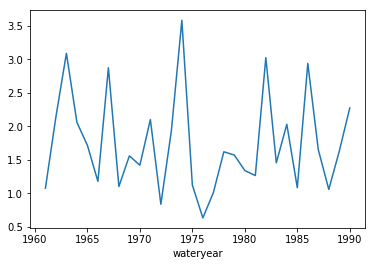

In [15]:
# Create Annual Maximum Series
baselineDF_max = baselineDF.groupby('wateryear').value.max()
baselineDF_max.plot()

In [16]:
# Create an array of maximum values 
AMS = list(baselineDF_max)

### Using SciPy

(-0.07494807455362251, 1.3933479370190371, 0.5390652942187092)


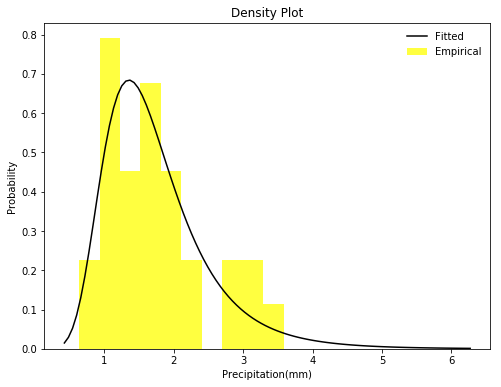

In [17]:
# Calculate distribution parameters
params = genextreme.fit(AMS)
c, loc, scale = params
print(params)

# Fit of GEV distribution based on MLE estimation (default in SciPy)
gev_fit = genextreme(*params)

# DENSITY PLOT 

# x axis values for plot
x = np.linspace(gev_fit.ppf(0.001), gev_fit.ppf(0.999), 100)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, gev_fit.pdf(x), label = 'Fitted', color = 'k')
ax.hist(AMS, density = True, 
                color = 'yellow', alpha = 0.75, label = "Empirical")
ax.set_title('Density Plot')
ax.set_xlabel('Precipitation(mm)')
ax.set_ylabel('Probability')
ax.legend(loc='best', frameon=False) 

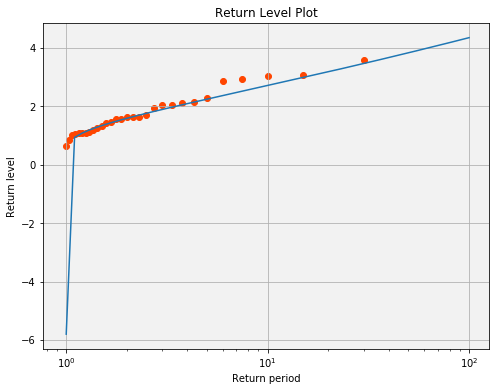

In [18]:
# RETURN VALUE PLOT

# Value indicating the frecuency of events per year
# frec of 1 => yearly data (1 value per year)
frec = 1

# x axis values for plot
T = np.arange(0.1, 100.1, 0.1)
sT = gev_fit.isf(frec * 1./T)
N = np.r_[1:len(AMS)+1] * frec
Nmax = max(N)

 # plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor((0.95, 0.95, 0.95))
plt.setp(ax.lines, linewidth = 2, color = 'magenta')
ax.set_title('Return Level Plot')
ax.set_xlabel('Return period')
ax.set_ylabel('Return level')
ax.grid(True)
ax.semilogx(T, sT)
ax.scatter(frec * Nmax/N, sorted(AMS)[::-1], color = 'orangered')

In [19]:
# Get Return Levels (precipitation values) for Return Periods
print('2-year Return Level = ', gev_fit.isf(1./2), 'inch')
print('5-year Return Level = ', gev_fit.isf(1./5), 'inch')
print('10-year Return Level = ', gev_fit.isf(1./10), 'inch')
print('20-year Return Level = ', gev_fit.isf(1./20), 'inch')
print('50-year Return Level = ', gev_fit.isf(1./50), 'inch')
print('100-year Return Level = ', gev_fit.isf(1./100), 'inch')

2-year Return Level =  1.5936609800218537 inch
5-year Return Level =  2.2491140658259168 inch
10-year Return Level =  2.7147458746217867 inch
20-year Return Level =  3.1866852038118343 inch
50-year Return Level =  3.836617808580886 inch
100-year Return Level =  4.354280477009514 inch


### Using lmoments3

In [20]:
# Calculate distribution parameters
params = distr.gev.lmom_fit(AMS)

# Fit of GEV distribution based on L-moments estimation
gev_fit = distr.gev(**params)

print(params)

OrderedDict([('c', -0.06646490493532098), ('loc', 1.384841704002104), ('scale', 0.5612270956812114)])


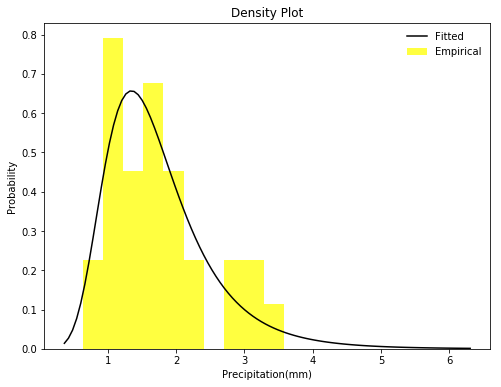

In [21]:
# DENSITY PLOT

# x axis values for plot
x = np.linspace(gev_fit.ppf(0.001), gev_fit.ppf(0.999), 100)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, gev_fit.pdf(x), label = 'Fitted', color = 'k')
ax.hist(AMS, density = True, 
                color = 'yellow', alpha = 0.75, label = "Empirical")
ax.set_title('Density Plot')
ax.set_xlabel('Precipitation(mm)')
ax.set_ylabel('Probability')
ax.legend(loc='best', frameon=False)  

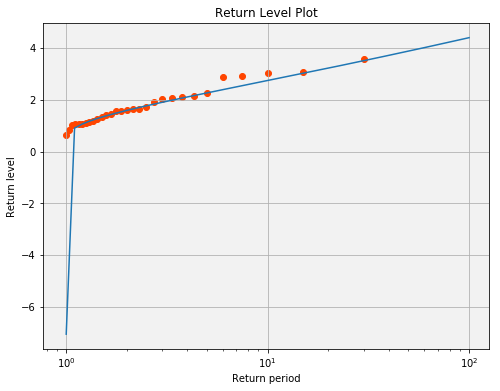

In [22]:
# RETURN VALUE PLOT

# Value indicating the frecuency of events per year
# frec of 1 => yearly data (1 value per year)
frec = 1

# x axis values for plot
T = np.arange(0.1, 100.1, 0.1)
sT = gev_fit.isf(frec * 1./T)
N = np.r_[1:len(AMS)+1] * frec
Nmax = max(N)

 # plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor((0.95, 0.95, 0.95))
plt.setp(ax.lines, linewidth = 2, color = 'magenta')
ax.set_title('Return Level Plot')
ax.set_xlabel('Return period')
ax.set_ylabel('Return level')
ax.grid(True)
ax.semilogx(T, sT)
ax.scatter(frec * Nmax/N, sorted(AMS)[::-1], color = 'orangered')

In [23]:
# Get Return Levels (precipitation values) for Return Periods
print('2-year Return Level = ', gev_fit.isf(1./2), 'inch')
print('5-year Return Level = ', gev_fit.isf(1./5), 'inch')
print('10-year Return Level = ', gev_fit.isf(1./10), 'inch')
print('20-year Return Level = ', gev_fit.isf(1./20), 'inch')
print('50-year Return Level = ', gev_fit.isf(1./50), 'inch')
print('100-year Return Level = ', gev_fit.isf(1./100), 'inch')

2-year Return Level =  1.593064569209831 inch
5-year Return Level =  2.2700398312707613 inch
10-year Return Level =  2.7471506288588734 inch
20-year Return Level =  3.227719238228814 inch
50-year Return Level =  3.8849041769880537 inch
100-year Return Level =  4.404746761306939 inch


### Approach 2: Peak Over Threshold/Parital Duration Series (PDS)

In [24]:
# CREATE PARTIAL DURATION SERIES

# Select threshold value

# Method 1 - Often the lowest value from the Annual Maximum Series is used as the threshold
min_AMS = np.min(AMS)

# Method 2 - Use a percentile threshold from all values

print(min_AMS, threshold90)

0.6351758977659225 0.6205563254244804


In [25]:
th = 0.6

In [26]:
PDS = baselineDF['value'].values
print('Number of observations in PDS =', len(PDS))

Number of observations in PDS = 10957


### Using SciPy

In [27]:
data = PDS[PDS > th] - th

# Calculate distribution parameters
params_nofloc = genpareto.fit(PDS[PDS > th] - th)
c, loc, scale = params_nofloc
print('without floc argument', params_nofloc)

params = genpareto.fit(PDS[PDS > th] - th, floc=0)
c, loc, scale = params
print('with floc argument', params)

# Fit of GEV distribution based on MLE estimation (default in SciPy)
gpa_fit = genpareto(*params)

without floc argument (0.13929724256297166, 0.00145222686212286, 0.34266135541621423)
with floc argument (0.13442109011338754, 0, 0.3456827455233039)


/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [28]:
args = genpareto._fitstart(data)
x0, func, restore, args = genpareto._reduce_func(args, {})
res = optimize.minimize(func, x0, args=(data,), method='Nelder-Mead')
res

/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


 final_simplex: (array([[0.13929724, 0.00145223, 0.34266136],
       [0.13921769, 0.00145221, 0.34262494],
       [0.13934281, 0.00145223, 0.34270811],
       [0.13925992, 0.0014522 , 0.34266109]]), array([19.44733238, 19.44733861, 19.44734659, 19.44734859]))
           fun: 19.447332383329353
       message: 'Optimization terminated successfully.'
          nfev: 190
           nit: 107
        status: 0
       success: True
             x: array([0.13929724, 0.00145223, 0.34266136])

In [29]:
genpareto.fit(data, floc=0)

/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0.13442109011338754, 0, 0.3456827455233039)

In [30]:
args = genpareto._fitstart(data)
x0, func, restore, args = genpareto._reduce_func(args, {})
res = optimize.fmin(func, x0, args=(data,))
res

Optimization terminated successfully.
         Current function value: 19.447332
         Iterations: 107
         Function evaluations: 190


/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


array([0.13929724, 0.00145223, 0.34266136])

In [31]:
#args = genpareto._fitstart(data)
args = genpareto.fit(data, floc=0)
x0, func, restore, args = genpareto._reduce_func(args, {})
res = optimize.minimize(func, x0, args=(data,), method='BFGS') #jac=None, options={'gtol': 1e-7}
res

/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2159: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


      fun: 20.654208330990116
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-5.72204590e-04, -8.27345276e+02, -2.18353271e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 496
      nit: 0
     njev: 97
   status: 2
  success: False
        x: array([0.13442109, 0.        , 0.34568275])

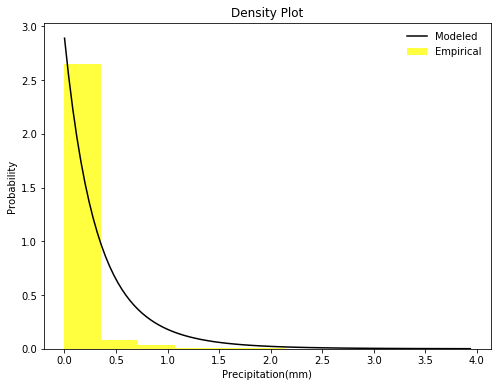

In [32]:
# DENSITY PLOT

# x axis values for plot
x = np.linspace(gpa_fit.ppf(0.001), gpa_fit.ppf(0.999), 100)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, gpa_fit.pdf(x), label = 'Modeled', color = 'k')
ax.hist(PDS, density = True, color = 'yellow', alpha = 0.75, label = "Empirical")
ax.set_title('Density Plot')
ax.set_xlabel('Precipitation(mm)')
ax.set_ylabel('Probability')
ax.legend(loc='best', frameon=False) 

In [33]:
# Function adapted from https://github.com/wcarthur/extremes


def returnLevels(intervals, mu, xi, sigma, rate, npyr):
    """
    Calculate return levels for specified intervals for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param intervals: :class:`numpy.ndarray` or float of recurrence intervals
              to evaluate return levels for.
    :param float mu: Threshold parameter (also called location).
    :param float xi: Shape parameter.
    :param float sigma: Scale parameter.
    :param float rate: Rate of exceedances (i.e. number of observations greater
                       than `mu`, divided by total number of observations).
    :param float npyr: Number of observations per year.

    :returns: return levels for the specified recurrence intervals.

    """

    rlevels = mu + (sigma / xi) * (np.power(intervals * npyr * rate, xi) - 1.)            
    return rlevels
    

def empReturnPeriod(data, npyr):
    """
    Returns the empirically-based recurrence interval (in years) for a set
    of observations.

    It is assumed the data are daily observations. If the observations are not
    daily, there are two options: set the ``npyr`` variable, or backfill the
    ``data`` variable with zero values to match the assumed length of the
    record.

    The highest return period should be (approximately) len(``data``)/``npyr``.

    :param data: :class:`numpy.ndarray` containing the observed values (with
                 missing values removed).
    :param float npy: Number of observations per year (default=365.25)

    :returns: Recurrence intervals for the observed data.
    :rtype: :class:`numpy.ndarray`
    """
    nobs = len(data)
    # Empirical return periods:
    emprp = 1. / (1. - np.arange(1, nobs + 1, 1) / (nobs + 1)) / npyr
    return emprp

In [395]:
def returnLevelWithCI(period, mu, sigma, xi, rate, npyr, data, conf=0.95):
    """
    Calculate return level with Confidence Interval for a specified period for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param float period: Recurrence interval
    :param float th: Threshold parameter (also called location).
    :param float sigma: Scale parameter.
    :param float xi: Shape parameter.
    :param float rate: Rate of exceedances (i.e. number of observations greater
                       than `mu`, divided by total number of observations).
    :param float npyr: Number of observations per year.
    :param float conf: The confidence level used.
    :returns: return level for the specified recurrence interval.

    """
    m = period * npyr
    cutoff =  special.chdtri(1, 1 - conf)
    lmax = genpareto.logpdf(data[data > mu], c=xi, loc=mu, scale=sigma)
    lmax = np.sum(lmax)
    # The largest [in magnitude] usable floating value.
    XMAX = np.finfo(float).max
    
    # Begin gpdlikelihood
    def gpdlik(shape, xp):
        if (shape == 0):
            scale = (xp - mu) / np.log(m * rate)
        else:
            scale = ((xp - mu) * shape) / (np.power(m * rate, shape) - 1)
        
        if (scale <= 0):
            out = XMAX
        else:
            out = genpareto.logpdf(data[data > mu], c=shape, loc=mu, scale=scale)
            out = np.sum(out)
            if(out == -float('Inf')):
                out = XMAX
        return -out

    # Begin prof
    def prof(xp):
        yes = optimize.minimize(gpdlik, [xi], args=(xp,))
        lci = -yes.fun
        return 2*(lmax-lci) - cutoff
    # End prof
    
    # Calculate return level
    est = mu + (sigma / xi) * (np.power(m * rate, xi) - 1.)
    print('Return Level for {} year return period: {}'.format(period, est))
    
    # Guess for intial bounds
    lower_bound = est - 1
    upper_bound = est + 1
    
    # Calculate confidence intervals
    try:
        ci_upper = optimize.brentq(prof, est, upper_bound)
        print('Confidence Interval (upper):', ci_upper)
    except ValueError as e:
        print('Confidence Interval (upper):', e)
        
    try:
        ci_lower = optimize.brentq(prof, lower_bound, est)
        print('Confidence Interval (lower):', ci_lower)
    except ValueError as e:
        print('Confidence Interval (lower):', e)

In [396]:
returnLevelWithCI(5, 0.6, params[2], params[0], rate, npyr, PDS)

Return Level for 5 year return period: 2.351483878229515
Confidence Interval (upper): 2.8461766337463015
Confidence Interval (lower): f(a) and f(b) must have different signs


/home/mukhtyar/projects/python-playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in double_scalars


In [375]:
rate = float(len(PDS[PDS > th])) / float(len(PDS))
npyr = len(PDS) / 30
print(th, params, rate, npyr, len(PDS))

0.6 (0.13442109011338754, 0, 0.3456827455233039) 0.026102035228620972 365.23333333333335 10957


In [ ]:
# RETURN VALUE PLOT

# x axis values for plot
rp = np.array([2, 5, 10, 20, 50, 100, 500])
rate = float(len(PDS[PDS > th])) / float(len(PDS))
npyr = len(PDS) / 30
rval = returnLevels(rp, th, params[0], params[2], rate, npyr)

print(rate, len(PDS))

emprp = empReturnPeriod(PDS, npyr)
sortedmax = np.sort(PDS)

 # plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Return Level Plot')
ax.set_xlabel('Return period')
ax.set_ylabel('Return level')
ax.grid(True)
ax.semilogx(rp, rval, label = 'Modeled RP', color = 'k')
ax.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100, color='r', label="Empirical RP")
ax.legend(loc='best', frameon=False) 

In [ ]:
# Get Return Levels (precipitation values) for Return Periods
print('2-year Return Level = ', rval[0], 'inch')
print('5-year Return Level = ', rval[1], 'inch')
print('10-year Return Level = ', rval[2], 'inch')
print('20-year Return Level = ', rval[3], 'inch')
print('50-year Return Level = ', rval[4], 'inch')
print('100-year Return Level = ', rval[5], 'inch')

#### Calculate Confidence Intervals

### Using lmoments3

In [ ]:
# Calculate distribution parameters
params = distr.gpa.lmom_fit(PDS[PDS > th] - th)

# Fit of Generalised Pareto distribution based on L-moments estimation
gpa_fit = distr.gpa(**params)

print(params)

In [ ]:
args = genpareto._fitstart(data)
x0, func, restore, args = genpareto._reduce_func(args, {})
res = minimize(func, x0, args=(data,), method='Nelder-Mead')
res

In [ ]:
# DENSITY PLOT

# x axis values for plot
x = np.linspace(gpa_fit.ppf(0.001), gpa_fit.ppf(0.999), 100)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, gpa_fit.pdf(x), label = 'Fitted', color = 'k')
ax.hist(PDS, density = True, 
                color = 'yellow', alpha = 0.75, label = "Empirical")
ax.set_title('Density Plot')
ax.set_xlabel('Precipitation(mm)')
ax.set_ylabel('Probability')
ax.legend(loc='best', frameon=False) 

In [ ]:
# RETURN VALUE PLOT

# x axis values for plot
rp = np.array([2, 5, 10, 20, 50, 100, 500])
rate = float(len(PDS[PDS > th])) / float(len(PDS))
npyr = len(PDS) / 30
rval = returnLevels(rp, th, params['c'], params['scale'], rate, npyr)

emprp = empReturnPeriod(PDS, npyr)
sortedmax = np.sort(PDS)

 # plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Return Level Plot')
ax.set_xlabel('Return period')
ax.set_ylabel('Return level')
ax.grid(True)
ax.semilogx(rp, rval, label = 'Modeled RP', color = 'k')
ax.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100, color='r', label="Empirical RP")
ax.legend(loc='best', frameon=False) 

In [ ]:
# Get Return Levels (precipitation values) for Return Periods
print('2-year Return Level = ', rval[0], 'inch')
print('5-year Return Level = ', rval[1], 'inch')
print('10-year Return Level = ', rval[2], 'inch')
print('20-year Return Level = ', rval[3], 'inch')
print('50-year Return Level = ', rval[4], 'inch')
print('100-year Return Level = ', rval[5], 'inch')